In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

In [3]:
# Decorador per mesurar el temps d'execució. S'utilitza posant @time_it a sobre de la funció.
def time_it(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  
        result = func(*args, **kwargs)  
        end_time = time.time()  
        execution_time = end_time - start_time 
        print(f"Temps d'execució de la funció {func.__name__}: {execution_time:.4f} segons")
        return result  
    return wrapper

In [114]:
file = "dataset.csv"
dataset = pd.read_csv(file)
print(dataset.head())

   id  age  year  sex  glang  part  job  stud_h  health  psyt  jspe  qcae_cog  \
0   2   18     1    1    120     1    0      56       3     0    88        62   
1   4   26     4    1      1     1    0      20       4     0   109        55   
2   9   21     3    2      1     0    0      36       3     0   106        64   
3  10   21     2    2      1     0    1      51       5     0   101        52   
4  13   21     3    1      1     1    0      22       4     0   102        58   

   qcae_aff  amsp  erec_mean  cesd  stai_t  mbi_ex  mbi_cy  mbi_ea  
0        27    17   0.738095    34      61      17      13      20  
1        37    22   0.690476     7      33      14      11      26  
2        39    17   0.690476    25      73      24       7      23  
3        33    18   0.833333    17      48      16      10      21  
4        28    21   0.690476    14      46      22      14      23  


Eliminem la columna de id ja que no té cap rellevància en la qüestió. També treiem la columna amsp ja que no entenem que representa. 

In [115]:
df = dataset.drop(['id', 'amsp'], axis=1)
# df = dataset.drop(['id', 'amsp', 'cesd',  'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea'], axis=1)

Separem entre variables numèriques, categòriques i treiem les columnes de cesd (depressió), stai_t (ansietat), 

In [6]:
df_cat = df[['sex', 'year', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']]
df_num = df[['age', 'jspe', 'qcae_cog', 'qcae_aff', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']]
# df_cat = df[['sex', 'year', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']]
# df_num = df[['age', 'jspe', 'qcae_cog', 'qcae_aff', 'erec_mean']]

vars_categoriques = ['sex', 'year', 'glang', 'part', 'job', 'stud_h', 'health', 'psyt']
vars_num = ['age', 'jspe', 'qcae_cog', 'qcae_aff', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']
vars_bin = ['part', 'job', 'psyt']

# Mesures de Rendiment

c:\Users\joanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\joanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\joanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\joanc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

Millor K elbow: 2
Millor k silhouette: 3


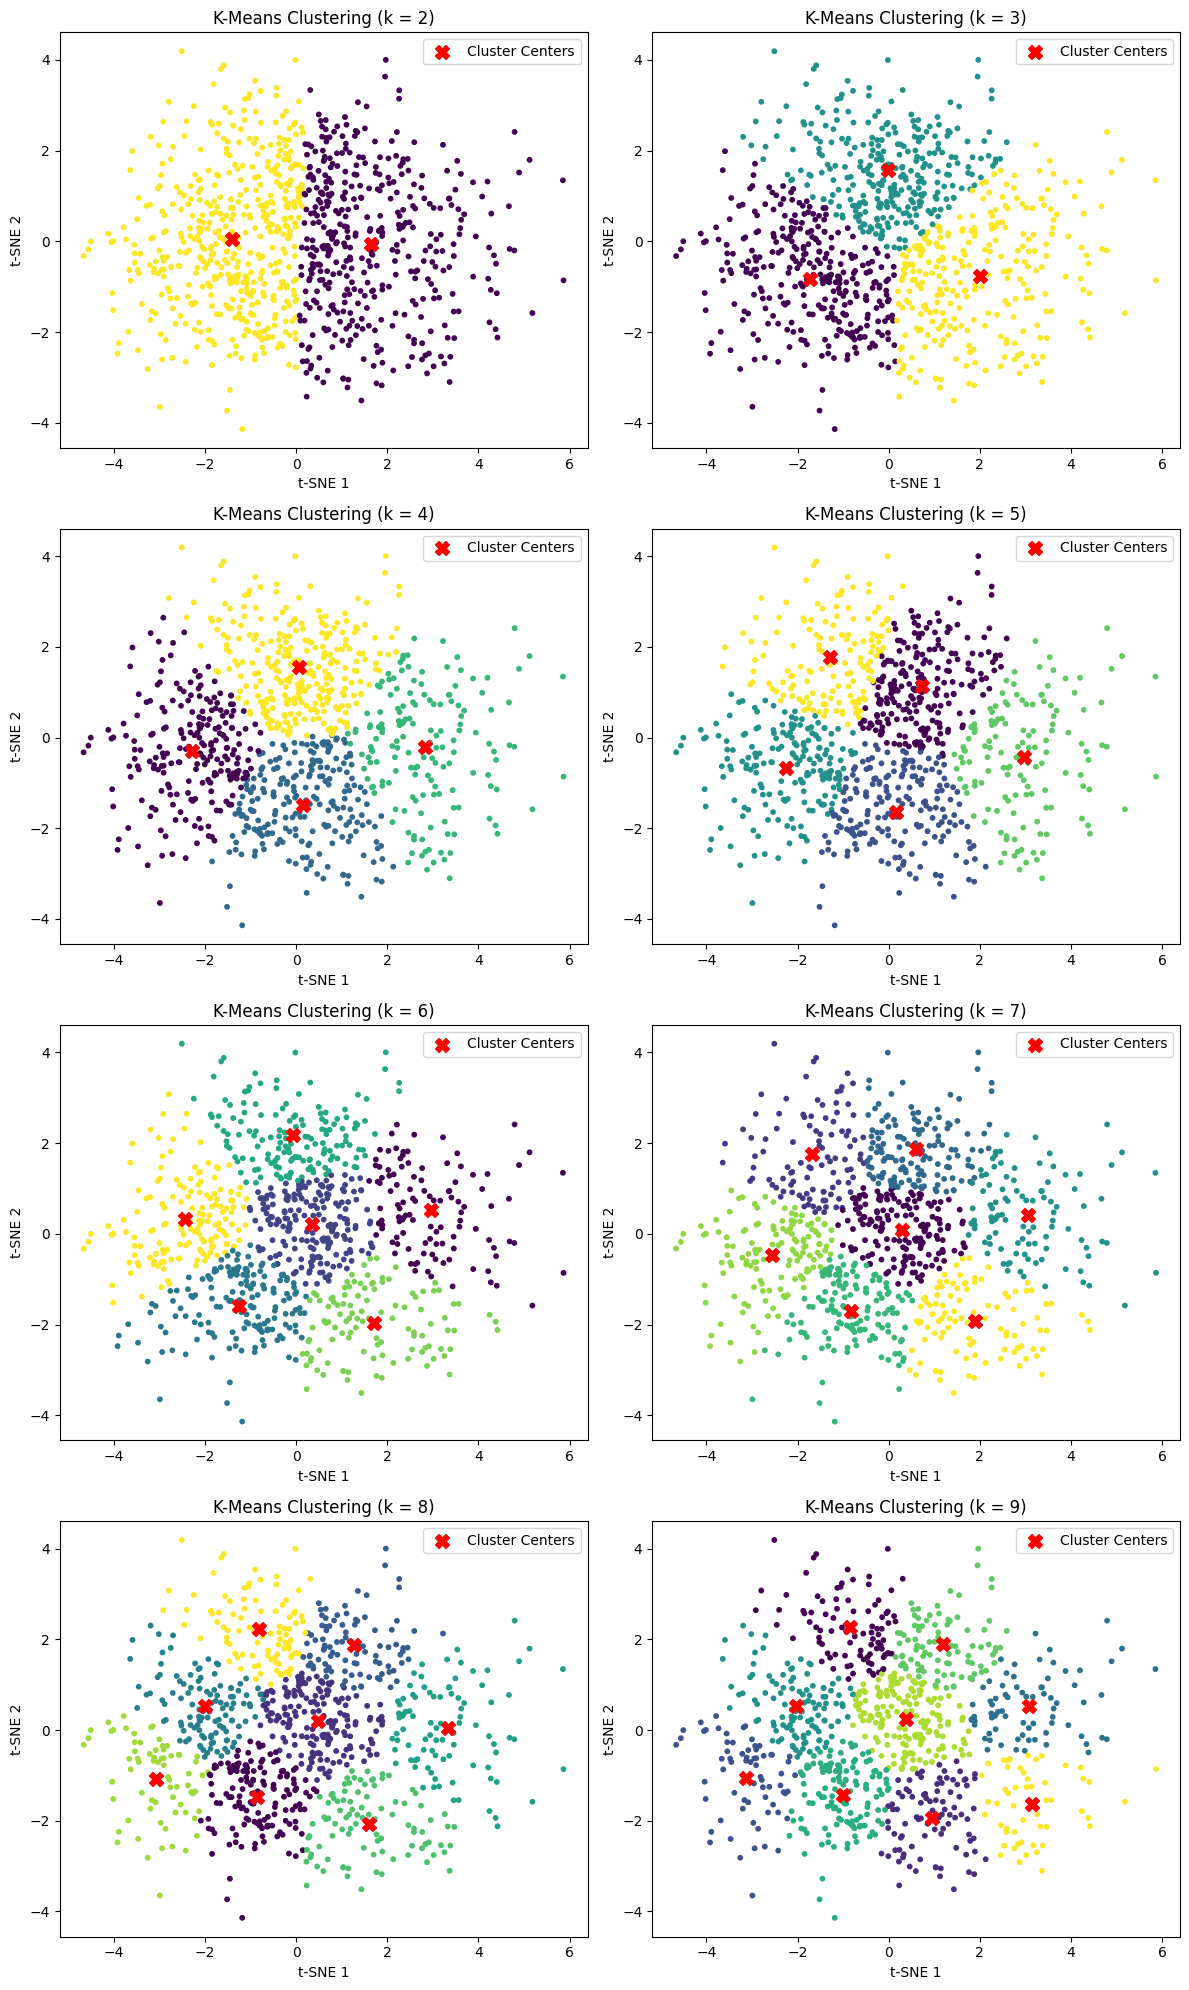

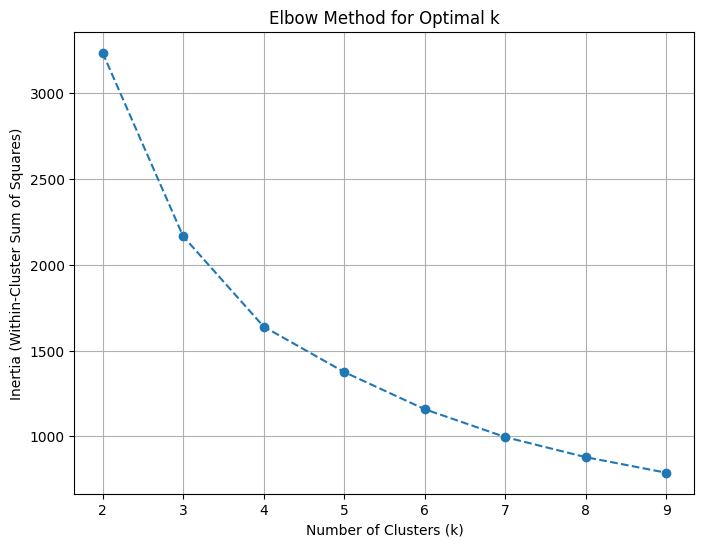

Temps d'execució de la funció kmeans_pca: 2.0468 segons


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

@time_it
def kmeans_pca(df, max_k):
    scaler = StandardScaler()
    df_num_scaled = scaler.fit_transform(df)
    # df_num_scaled = df.copy()

    pca = PCA(n_components=2)
    pca.fit(df_num_scaled)
    pca_features = pca.transform(df_num_scaled)

    
    # Store inertia values and clustering results for plotting
    inertia = []
    clusterings = []

    sil_best_score = -1
    sil_best_k = 2

    for k in range(2, max_k + 1):
        model = KMeans(n_clusters=k, random_state=42)
        clusters = model.fit_predict(pca_features)
        
        # Silhouette
        score = silhouette_score(pca_features, clusters)
        if score > sil_best_score:
            sil_best_score = score
            sil_best_k = k
        ##


        inertia.append(model.inertia_)
        cluster_centers = model.cluster_centers_
        clusterings.append((k, clusters, cluster_centers))

    # Elbow
    inertia_diff = np.diff(inertia)
    inertia_diff2 = np.diff(inertia_diff)
    optimal_k = np.argmax(inertia_diff2) + 2
    print("Millor K elbow:", optimal_k)

    # Silhouette 
    print("Millor k silhouette:", sil_best_k)

    # Plot clustering results for each k, 2 plots per row
    num_plots = len(clusterings)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols  # Calculate required rows

    plt.figure(figsize=(12, 5 * num_rows))
    
    for i, (k, clusters, centers) in enumerate(clusterings, 1):
        plt.subplot(num_rows, num_cols, i)
        plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis', s=10)
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Cluster Centers')
        plt.title(f'K-Means Clustering (k = {k})')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot the inertia (Elbow Method)
    plt.figure(figsize=(8, 6))
    k_values = range(2, max_k + 1)
    plt.plot(k_values, inertia, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()


kmeans_pca(df_max_scaled, 9)

Millor K elbow: 2
Millor k silhouette: 7


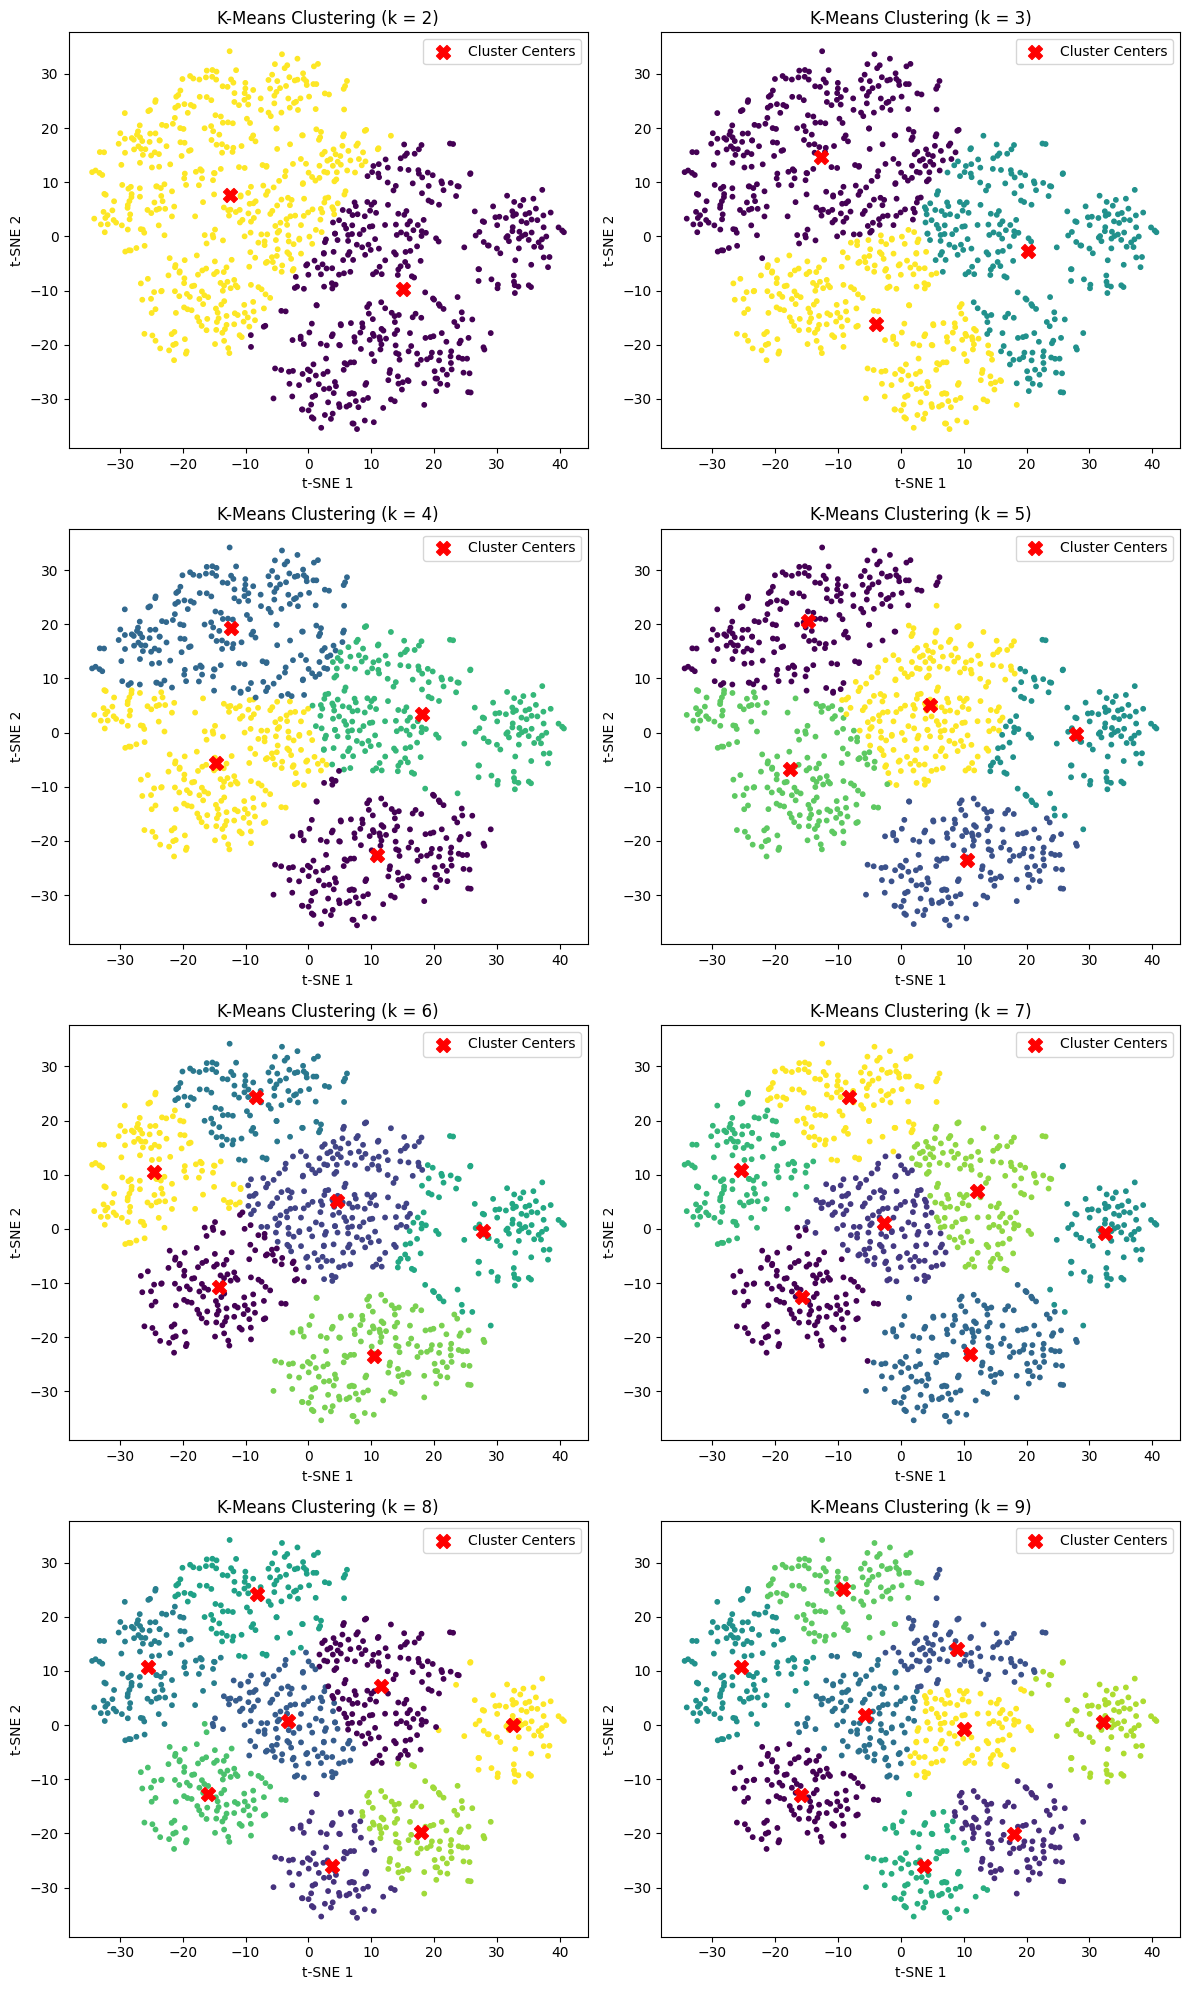

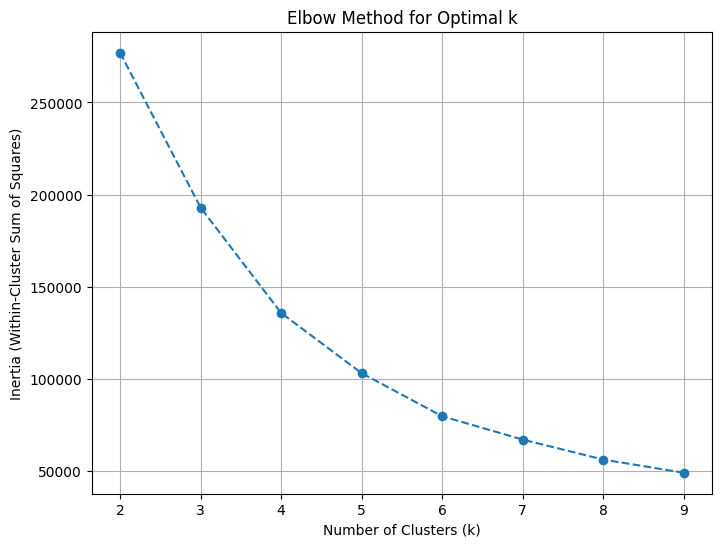

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def kmeans_tsne(dfs, max_k=10, features_to_plot=None):
    df_t = dfs.copy()
    
    # Standardize the dataset
    scaler = StandardScaler()
    df_num_scaled = scaler.fit_transform(df_t)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(df_num_scaled)

    # Store inertia values and clustering results for plotting
    inertia = []
    clusterings = []

    sil_best_score = -1
    sil_best_k = 2

    for k in range(2, max_k + 1):
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = model.fit_predict(tsne_features)
        
        # Silhouette
        score = silhouette_score(tsne_features, clusters)
        if score > sil_best_score:
            sil_best_score = score
            sil_best_k = k
        ##


        inertia.append(model.inertia_)
        cluster_centers = model.cluster_centers_
        clusterings.append((k, clusters, cluster_centers))

    # Elbow
    inertia_diff = np.diff(inertia)
    inertia_diff2 = np.diff(inertia_diff)
    optimal_k = np.argmax(inertia_diff2) + 2
    print("Millor K elbow:", optimal_k)

    # Silhouette 
    print("Millor k silhouette:", sil_best_k)

    # Plot clustering results for each k, 2 plots per row
    num_plots = len(clusterings)
    num_cols = 2
    num_rows = (num_plots + 1) // num_cols  # Calculate required rows

    plt.figure(figsize=(12, 5 * num_rows))
    
    for i, (k, clusters, centers) in enumerate(clusterings, 1):
        plt.subplot(num_rows, num_cols, i)
        plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=clusters, cmap='viridis', s=10)
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Cluster Centers')
        plt.title(f'K-Means Clustering (k = {k})')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot the inertia (Elbow Method)
    plt.figure(figsize=(8, 6))
    k_values = range(2, max_k + 1)
    plt.plot(k_values, inertia, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

    k_def = 4
    
    return clusterings
    

c = kmeans_tsne(df, 9, ['cesd', 'stai_t', 'mbi_ex', 'health'])

<Figure size 1200x800 with 0 Axes>

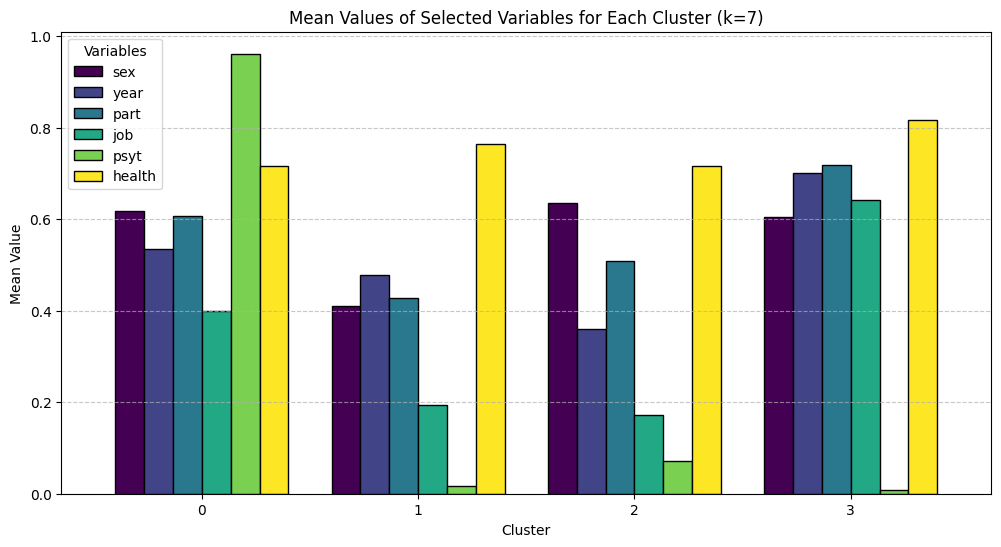

<Figure size 1200x800 with 0 Axes>

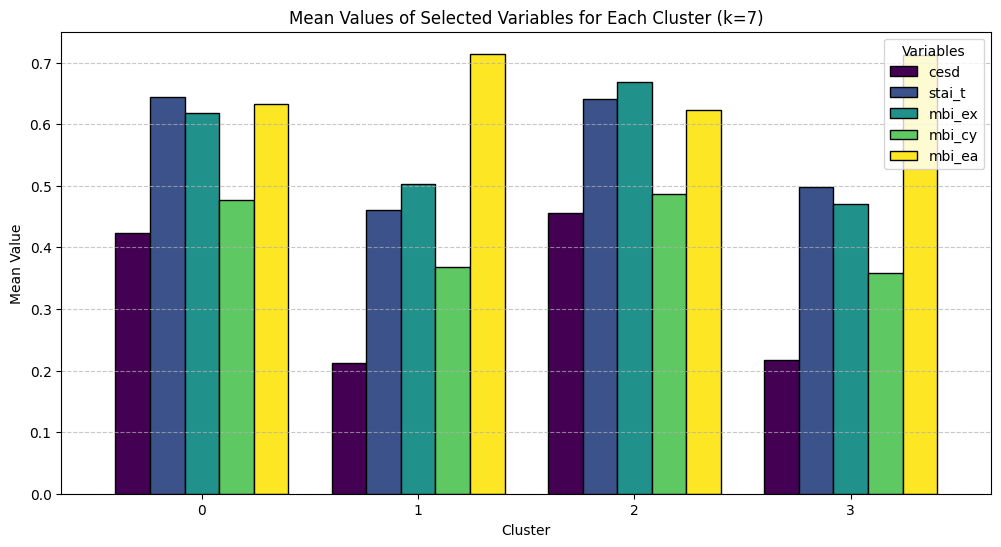

In [136]:
k_def = 4
df_t = df_max_scaled.copy()
cats = ['sex', 'year', 'part', 'job', 'psyt', 'health']
# nums = ['age', 'jspe', 'qcae_cog', 'qcae_aff', 'erec_mean', 'cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']
nums = ['cesd', 'stai_t', 'mbi_ex', 'mbi_cy', 'mbi_ea']



for k, clusters, _ in c:
        if k == k_def:
            df_t["Cluster"] = clusters  # Add cluster labels to the DataFrame
            
            means = {}
            for cluster in range(k_def):
                cluster_data = df_t[df_t["Cluster"] == cluster]
                means[cluster] = cluster_data[cats].mean()

            means2 = {}
            for cluster in range(k_def):
                cluster_data = df_t[df_t["Cluster"] == cluster]
                means2[cluster] = cluster_data[nums].mean()
            
            # Create a DataFrame for mean values
            mean_df_cat = pd.DataFrame(means).T
            mean_df_cat.columns = cats # variables categòriques a mostrar en el gràfic
            mean_df_cat.index.name = 'Cluster'

            # Plot the mean values for each cluster
            plt.figure(figsize=(12, 8))
            mean_df_cat.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black', width=0.8)
            plt.title('Mean Values of Selected Variables for Each Cluster (k=7)')
            plt.xlabel('Cluster')
            plt.ylabel('Mean Value')
            plt.xticks(rotation=0)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.legend(title='Variables')
            plt.show()

            mean_df_num = pd.DataFrame(means2).T
            mean_df_num.columns = nums # Variables numèriques a mostrar en el gràfic
            mean_df_num.index.name = 'Cluster'

            # Plot the mean values for each cluster
            plt.figure(figsize=(12, 8))
            mean_df_num.plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black', width=0.8)
            plt.title('Mean Values of Selected Variables for Each Cluster (k=7)')
            plt.xlabel('Cluster')
            plt.ylabel('Mean Value')
            plt.xticks(rotation=0)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.legend(title='Variables')
            plt.show()
            break

GMM clustering completed with 3 components.


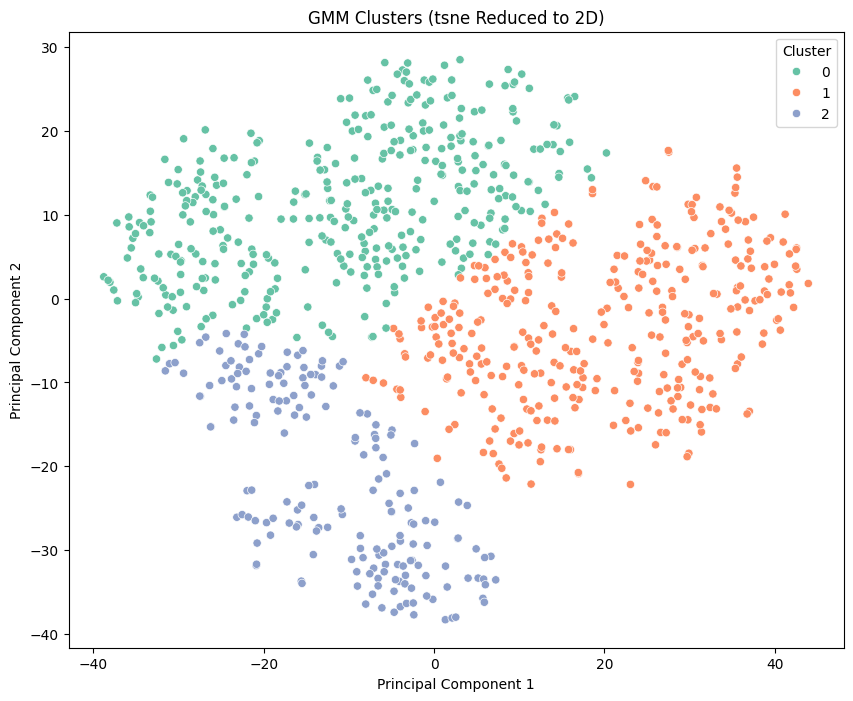

In [35]:
from sklearn.mixture import GaussianMixture

n_clusters = 3

df_c = df_max_scaled.copy()

scaler = StandardScaler()
df_num_scaled = scaler.fit_transform(df_c)

tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(df_num_scaled)

gmm = GaussianMixture(n_components=3, covariance_type='full').fit(tsne_features)
labels = gmm.predict(tsne_features)
df_c['GMM_Cluster'] = labels
print(f"GMM clustering completed with {n_clusters} components.")

# plot

# pca = PCA(n_components=2)
# components = pca.fit_transform(df_c)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=df_c['GMM_Cluster'], palette='Set2')
plt.title('GMM Clusters (tsne Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Cluster")
plt.show()
